<a href="https://colab.research.google.com/github/AB69D/ML-Colabratory/blob/main/Copy_of_apple_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras import Input, layers, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!touch DataSet.zip

In [ ]:
directory_train = "/content/drive/MyDrive/Colab Notebooks/DataSet/apple_disease_classification/Train"
directory_test = "/content/drive/MyDrive/Colab Notebooks/DataSet/apple_disease_classification/Test"



Base Model


# Before Augmentation

In [ ]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         validation_split=validation_split)
    return image_generator

In [ ]:
def get_generator(image_data_generator, directory, train_valid=None, seed=12):
    train_generator = image_data_generator.flow_from_directory(
                                                                directory,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224,224),
                                                                subset=train_valid,
                                                                seed=seed,
                                                                shuffle=True)
    return train_generator

In [ ]:
image_gen_train = get_ImageDataGenerator(validation_split=0.2)

train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')


Found 1280 images belonging to 4 classes.
Found 319 images belonging to 4 classes.


In [ ]:
image_gen_test = get_ImageDataGenerator(validation_split=None)
test_generator = get_generator(image_gen_test, directory_test)

Found 378 images belonging to 4 classes.


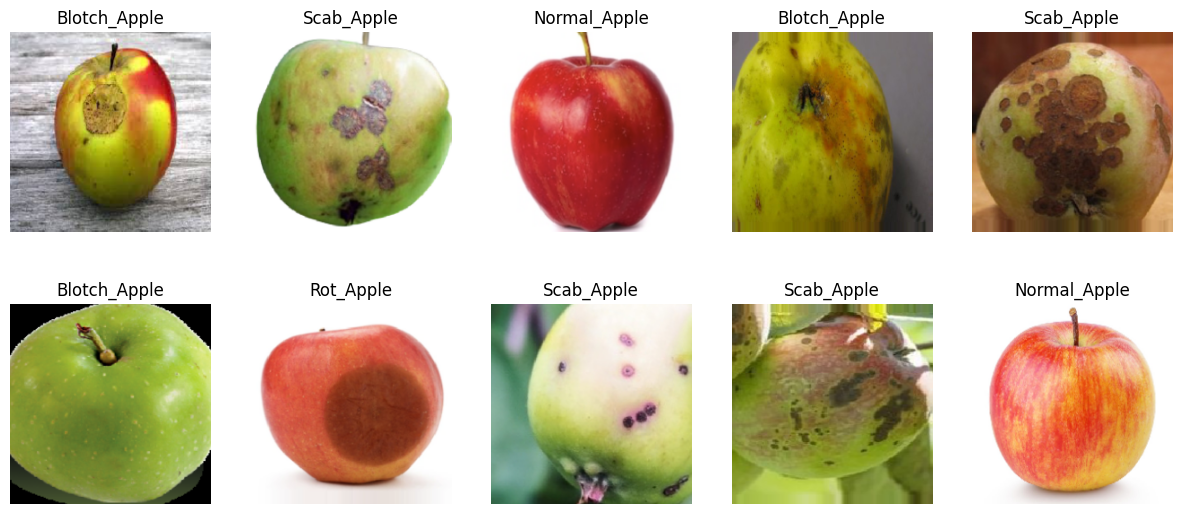

In [ ]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [ ]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    # h = BatchNormalization(axis=-1)(h)

    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    # h = BatchNormalization(axis=-1)(h)


    h = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    # h = BatchNormalization(axis=-1)(h)

    h = Flatten()(h)
    h = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    h = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(h)
    # h = Dropout(.5)(h)
    # h = BatchNormalization()(h)
    output = Dense(4, activation='softmax')(h)
    # print(target_labels.shape[0])
    model = tf.keras.Model(inputs=x, outputs=output)

    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model


In [ ]:
benchmark_model = get_benchmark_model((224, 224, 3))
benchmark_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                         

In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size

    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_gen,
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        batch_size = 32,
                        validation_data=valid_gen,
                        callbacks=[earlystopping]
                       )

    return history

In [ ]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training')
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')


Found 1280 images belonging to 4 classes.
Found 319 images belonging to 4 classes.


In [ ]:
history_benchmark = train_model(benchmark_model, train_generator, validation_generator, 50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 [==============================] - 859s 21s/step - loss: 4.3722 - accuracy: 0.3953 - val_loss: 2.7934 - val_accuracy: 0.4577
Epoch 2/50
40/40 [==============================] - 405s 10s/step - loss: 2.3279 - accuracy: 0.4625 - val_loss: 2.0199 - val_accuracy: 0.4671
Epoch 3/50
26/40 [==================>...........] - ETA: 2:05 - loss: 1.8762 - accuracy: 0.5120

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_benchmark.history['accuracy'])
plt.plot(history_benchmark.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_steps = test_generator.n // test_generator.batch_size
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset:')
print("Loss: {}".format(benchmark_test_loss))
print("Accuracy: {}".format(benchmark_test_acc))

# After Data Augmentation


In [ ]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=30,
                                        width_shift_range=0.2,
                                        height_shift_range=0.5,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.5,1.0],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator

In [ ]:
image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.2)

In [ ]:

train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')

Found 1280 images belonging to 4 classes.
Found 319 images belonging to 4 classes.


In [ ]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)

Found 1280 images belonging to 4 classes.


In [ ]:
batch = next(train_generator)

In [ ]:
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

In [ ]:
aug_batch = next(train_generator_aug)


In [ ]:
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

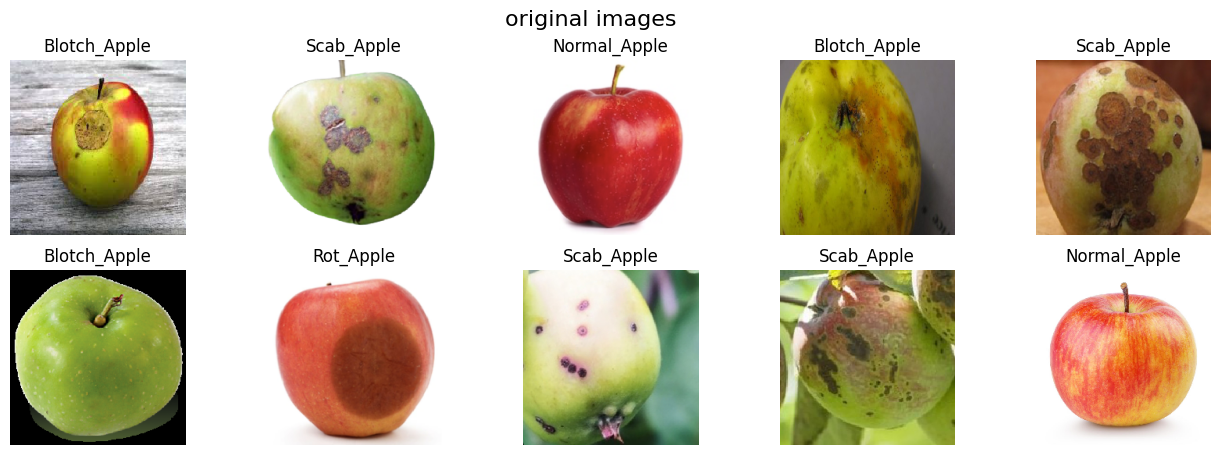

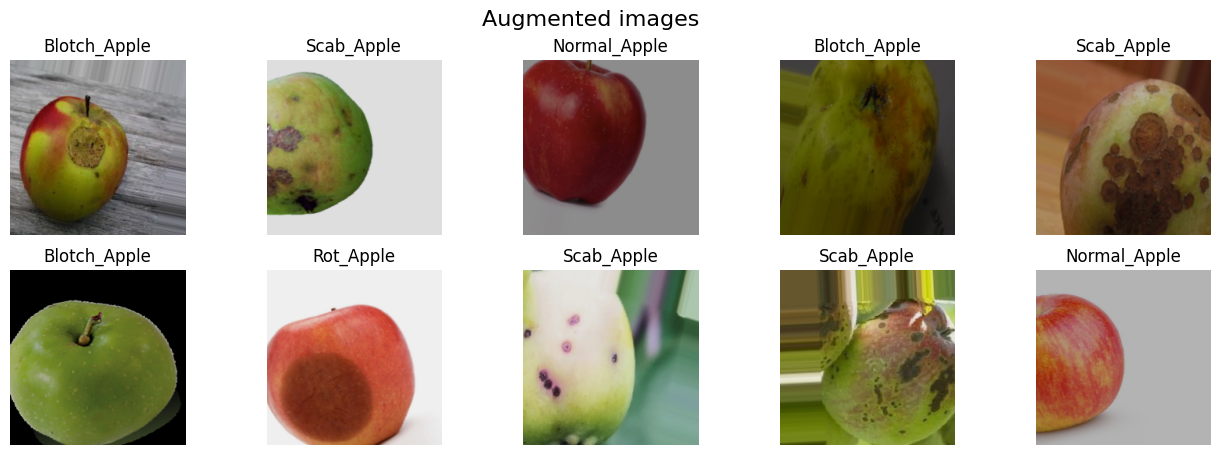

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle("original images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [ ]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training')

Found 1280 images belonging to 4 classes.


In [ ]:
benchmark_model_aug = benchmark_model
benchmark_model_aug.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_111 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 conv2d_113 (Conv2D)         (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                     

In [ ]:
history_augmented = train_model(benchmark_model_aug, train_generator_aug, validation_generator_aug, epochs=30)

Epoch 1/30
40/40 [==============================] - 34s 852ms/step - loss: 0.7972 - accuracy: 0.7250 - val_loss: 0.9636 - val_accuracy: 0.6552
Epoch 2/30
40/40 [==============================] - 33s 830ms/step - loss: 0.8122 - accuracy: 0.7492 - val_loss: 0.7876 - val_accuracy: 0.7241
Epoch 3/30
40/40 [==============================] - 33s 829ms/step - loss: 0.7740 - accuracy: 0.7422 - val_loss: 0.7924 - val_accuracy: 0.7367
Epoch 4/30
40/40 [==============================] - 32s 804ms/step - loss: 0.7327 - accuracy: 0.7539 - val_loss: 0.7599 - val_accuracy: 0.7429
Epoch 5/30
40/40 [==============================] - 32s 801ms/step - loss: 0.7586 - accuracy: 0.7484 - val_loss: 0.7946 - val_accuracy: 0.7398
Epoch 6/30
40/40 [==============================] - 32s 799ms/step - loss: 0.7444 - accuracy: 0.7578 - val_loss: 0.7546 - val_accuracy: 0.7304
Epoch 7/30
40/40 [==============================] - 33s 826ms/step - loss: 0.7140 - accuracy: 0.7703 - val_loss: 0.8036 - val_accuracy: 0.7367

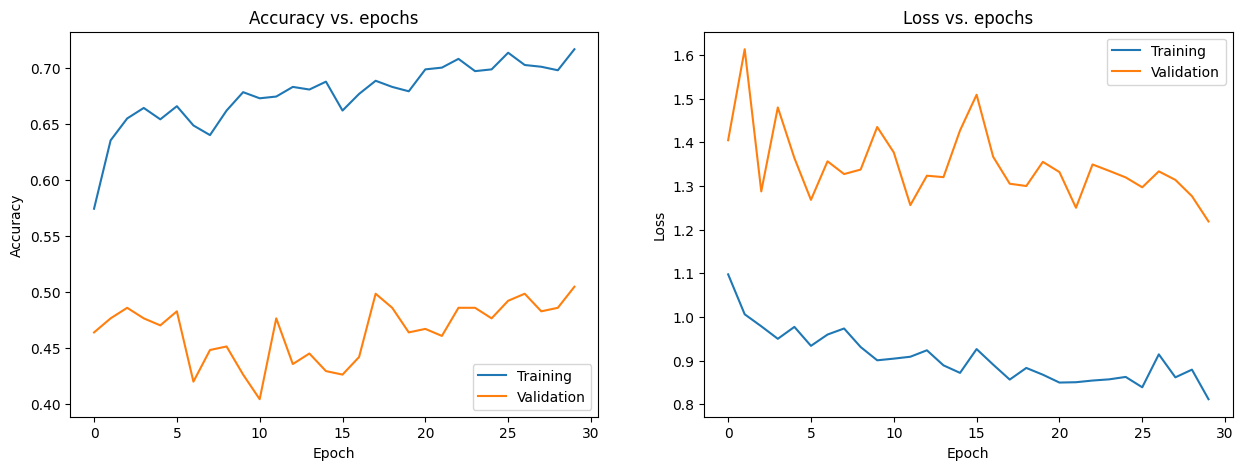

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_generator = get_generator(image_gen_test, directory_test)

Found 378 images belonging to 4 classes.


In [ ]:
augmented_model_test_loss, augmented_model_test_acc = benchmark_model_aug.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(augmented_model_test_loss))
print("Accuracy: {}".format(augmented_model_test_acc))

11/11 [==============================] - 3s 256ms/step - loss: 0.7291 - accuracy: 0.7045

Test dataset
Loss: 0.7290853261947632
Accuracy: 0.7045454382896423


In [ ]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

Found 378 images belonging to 4 classes.
11/11 [==============================] - 3s 245ms/step - loss: 0.2653 - accuracy: 0.9290

Test dataset
Loss: 0.26528337597846985
Accuracy: 0.9289772510528564


# Pre-Trained Model

In [ ]:
feature_extractor = tf.keras.applications.InceptionResNetV2(weights="imagenet")
feature_extractor.summary()

In [ ]:
def remove_head(feature_extractor_model):
    model_input = feature_extractor_model.input
    output = feature_extractor_model.get_layer(name='avg_pool').output
    model = tf.keras.Model(inputs=model_input, outputs=output)
    return model

In [ ]:
feature_extractor = remove_head(feature_extractor)
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])

    return model

In [ ]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1536)              54336736  
                                                                 
 dense_3 (Dense)             (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 54,533,988
Trainable params: 54,473,444
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
def freeze_pretrained_weights(model):
    model.get_layer(name='model').trainable=False

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1536)              54336736  
                                                                 
 dense_3 (Dense)             (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 54,533,988
Trainable params: 197,252
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size

    history = model.fit(train_gen,
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        batch_size = 32,
                        validation_data=valid_gen)

    return history

In [ ]:
history_frozen_new_model = train_model(frozen_new_model, train_generator, validation_generator, 30)

Epoch 1/30
 3/40 [=>............................] - ETA: 6:18 - loss: 1.8209 - accuracy: 0.2396

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 [==============================] - 987s 24s/step - loss: 1.1563 - accuracy: 0.5344 - val_loss: 0.7362 - val_accuracy: 0.7618
Epoch 2/30
40/40 [==============================] - 15s 364ms/step - loss: 0.8043 - accuracy: 0.6844 - val_loss: 0.5736 - val_accuracy: 0.8182
Epoch 3/30
40/40 [==============================] - 17s 408ms/step - loss: 0.6790 - accuracy: 0.7406 - val_loss: 0.5026 - val_accuracy: 0.8276
Epoch 4/30
40/40 [==============================] - 15s 365ms/step - loss: 0.6278 - accuracy: 0.7656 - val_loss: 0.5498 - val_accuracy: 0.7900
Epoch 5/30
40/40 [==============================] - 15s 366ms/step - loss: 0.5894 - accuracy: 0.7859 - val_loss: 0.4411 - val_accuracy: 0.8401
Epoch 6/30
40/40 [==============================] - 17s 429ms/step - loss: 0.5456 - accuracy: 0.7914 - val_loss: 0.4626 - val_accuracy: 0.8495
Epoch 7/30
40/40 [==============================] - 15s 358ms/step - loss: 0.5080 - accuracy: 0.8000 - val_loss: 0.4063 - val_accuracy: 0.8558
Epoch 8/30


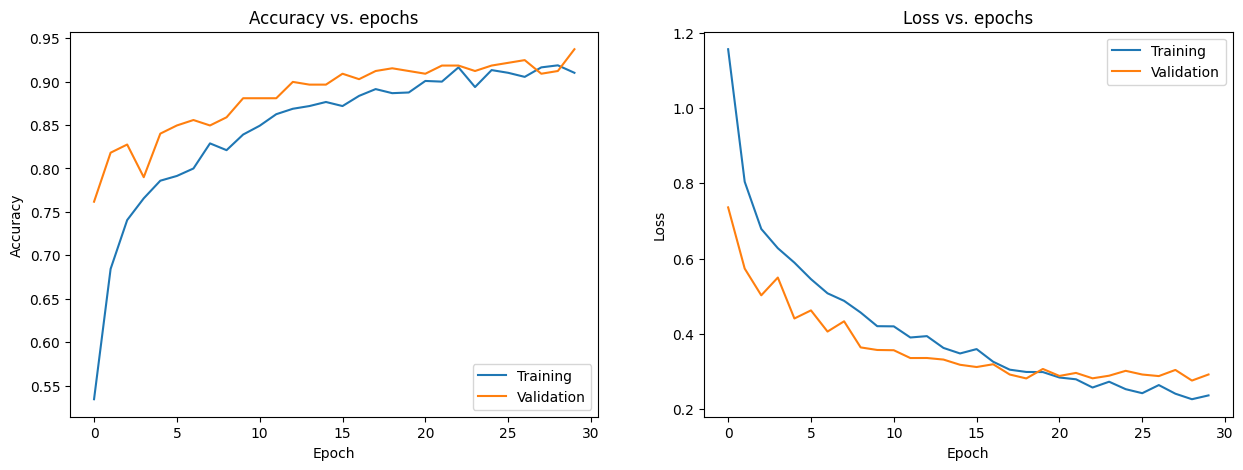

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Result Analysis

In [ ]:
benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]
benchmark_train_acc = history_benchmark.history['accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]
new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

augmented_model_train_loss = history_augmented.history['loss'][-1]
augmented_model_valid_loss = history_augmented.history['val_loss'][-1]
augmented_model_train_acc = history_augmented.history['accuracy'][-1]
augmented_model_valid_acc = history_augmented.history['val_accuracy'][-1]
comparison = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss, augmented_model_train_loss],
                            ['Validation loss', benchmark_valid_loss, new_model_valid_loss, augmented_model_valid_loss],
                           ['Test loss', benchmark_test_loss, new_model_test_loss, augmented_model_test_loss],
                          ['Training accuracy', benchmark_train_acc, new_model_train_acc, augmented_model_train_acc],
                          ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc, augmented_model_valid_acc],
                          ['Test accuracy', benchmark_test_acc, new_model_test_acc, augmented_model_test_acc]],
                           columns=['Metric', 'Benchmark CNN', 'Transfer Learning CNN', 'Custom CNN/Data Augmentation'])
comparison.index=['']*6
comparison

,Metric,Benchmark CNN,Transfer Learning CNN,Custom CNN/Data Augmentation
,Training loss,0.153628,0.236751,0.659192
,Validation loss,1.058305,0.292314,0.668744
,Test loss,0.638252,0.265283,0.729085
,Training accuracy,0.944531,0.910156,0.737500
,Validation accuracy,0.783699,0.937304,0.771160
,Test accuracy,0.903409,0.928977,0.704545


In [ ]:
test_generator = get_generator(image_gen_test, directory_test, seed=123)
predictions = benchmark_model_aug.predict(test_generator)

Found 378 images belonging to 4 classes.
12/12 [==============================] - 3s 276ms/step


In [ ]:

test_generator = get_generator(image_gen_test, directory_test, seed=123)
batches = []
for i in range(1):
    batches.append(next(test_generator))

batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

Found 378 images belonging to 4 classes.


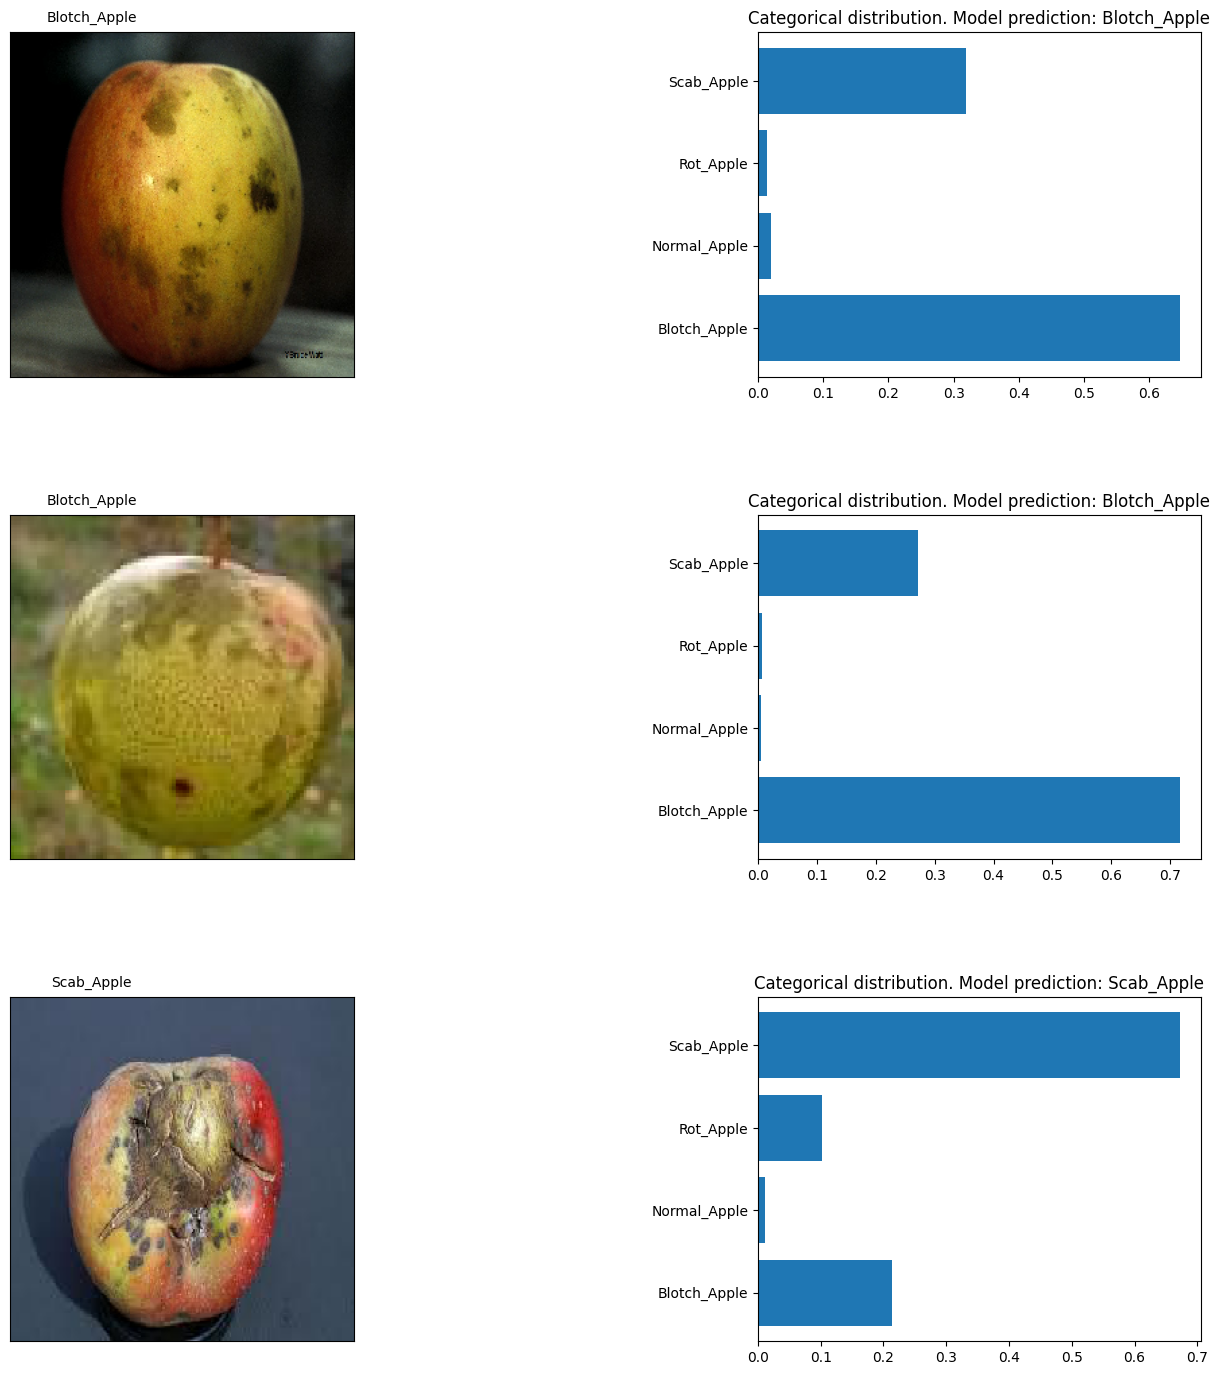

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 17))
fig.subplots_adjust(hspace = 0.4, wspace=0.8)
axes = axes.ravel()

for i in range(3):

    inx = np.random.choice(batch_images.shape[0], 1, replace=False)[0]

    axes[0+i*2].imshow(batch_images[inx])
    axes[0+i*2].get_xaxis().set_visible(False)
    axes[0+i*2].get_yaxis().set_visible(False)
    axes[0+i*2].text(60., -8, target_labels[np.where(batch_labels[inx]==1)[0][0]],
                    horizontalalignment='center')
    axes[1+i*2].barh(np.arange(len(predictions[inx])),predictions[inx])
    axes[1+i*2].set_yticks(np.arange(len(predictions[inx])))
    axes[1+i*2].set_yticklabels(target_labels)
    axes[1+i*2].set_title(f"Categorical distribution. Model prediction: {target_labels[np.argmax(predictions[inx])]}")

plt.show()

In [ ]:
from google.colab import files
files.download('apple_disease_classification.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>